In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")


In [2]:


# Load clinical data
clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')

# Load peptides data
peptides_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')

# Load proteins data
proteins_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')


In [3]:
print(clinical_data.head())
print(peptides_data.head())
print(proteins_data.head())


  visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0     55_0          55            0     10.0      6.0     15.0      NaN   
1     55_3          55            3     10.0      7.0     25.0      NaN   
2     55_6          55            6      8.0     10.0     34.0      NaN   
3     55_9          55            9      8.0      9.0     30.0      0.0   
4    55_12          55           12     10.0     10.0     41.0      0.0   

  upd23b_clinical_state_on_medication  
0                                 NaN  
1                                 NaN  
2                                 NaN  
3                                  On  
4                                  On  
  visit_id  visit_month  patient_id UniProt  \
0     55_0            0          55  O00391   
1     55_0            0          55  O00533   
2     55_0            0          55  O00533   
3     55_0            0          55  O00533   
4     55_0            0          55  O00533   

                          

In [4]:
peptides_agg = peptides_data.groupby(['patient_id', 'visit_month']).mean(numeric_only=True).reset_index()
proteins_agg = proteins_data.groupby(['patient_id', 'visit_month']).mean(numeric_only=True).reset_index()


In [5]:
print(peptides_agg.isnull().sum())
print(proteins_agg.isnull().sum())


patient_id          0
visit_month         0
PeptideAbundance    0
dtype: int64
patient_id     0
visit_month    0
NPX            0
dtype: int64


In [6]:
# Merge clinical data with aggregated peptides data
merged_df = pd.merge(clinical_data, peptides_agg, on=['patient_id', 'visit_month'], how='left')

# Merge the result with aggregated proteins data
merged_df = pd.merge(merged_df, proteins_agg, on=['patient_id', 'visit_month'], how='left')


In [7]:
print(merged_df.isnull().sum())



visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
PeptideAbundance                       1547
NPX                                    1547
dtype: int64


In [8]:
print(merged_df.head())
merged_df.to_csv('merged_parkinsons_data.csv', index=False)


  visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0     55_0          55            0     10.0      6.0     15.0      NaN   
1     55_3          55            3     10.0      7.0     25.0      NaN   
2     55_6          55            6      8.0     10.0     34.0      NaN   
3     55_9          55            9      8.0      9.0     30.0      0.0   
4    55_12          55           12     10.0     10.0     41.0      0.0   

  upd23b_clinical_state_on_medication  PeptideAbundance           NPX  
0                                 NaN     748153.907014  3.180508e+06  
1                                 NaN               NaN           NaN  
2                                 NaN     685218.599872  2.942039e+06  
3                                  On               NaN           NaN  
4                                  On     740535.423563  3.145608e+06  


In [9]:
#  Advanced Imputation
columns_to_fill = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 
                   'upd23b_clinical_state_on_medication', 'PeptideAbundance', 'NPX']

# Applying forward-fill and backward-fill to cover edge cases
merged_df[columns_to_fill] = merged_df[columns_to_fill].ffill().bfill()


In [10]:

#  Feature Transformations
# Log-transforming biomarkers to reduce skewness
merged_df['log_PeptideAbundance'] = np.log1p(merged_df['PeptideAbundance'])
merged_df['log_NPX'] = np.log1p(merged_df['NPX'])


In [11]:
#  Feature Engineering
# Sorting data to ensure correct temporal ordering for each patient
merged_df = merged_df.sort_values(by=['patient_id', 'visit_month'])

#  Create lag feature: previous UPDRS-III score for each patient
merged_df['prev_updrs_3'] = merged_df.groupby('patient_id')['updrs_3'].shift(1)
merged_df['prev_updrs_3'] = merged_df['prev_updrs_3'].ffill().bfill()

#  Create delta feature: difference between current and previous UPDRS-III
merged_df['delta_updrs_3'] = merged_df['updrs_3'] - merged_df['prev_updrs_3']
merged_df['delta_updrs_3'] = merged_df['delta_updrs_3'].ffill().bfill()

#  Create rolling average of previous UPDRS-III scores (window=2)
merged_df['rolling_updrs_3'] = merged_df.groupby('patient_id')['updrs_3'] \
    .transform(lambda x: x.rolling(window=2, min_periods=1).mean().shift(1))
merged_df['rolling_updrs_3'] = merged_df['rolling_updrs_3'].ffill().bfill()

#  Create interaction feature between log-transformed biomarkers
merged_df['interaction'] = merged_df['log_PeptideAbundance'] * merged_df['log_NPX']


In [12]:
merged_df.to_csv('/kaggle/working/merged_parkinsons_data_final.csv', index=False)


In [14]:
# -------------------------
# Step 5: EDA Graphs
# -------------------------
os.makedirs("/kaggle/working/eda_visuals", exist_ok=True)

# i. Distribution Plots
numerical_features = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'log_PeptideAbundance', 
                      'log_NPX', 'prev_updrs_3', 'delta_updrs_3', 'rolling_updrs_3', 'interaction']
skew_vals = merged_df[numerical_features].skew().sort_values()
    plt.figure(figsize=(10,5))
    sns.barplot(x=skew_vals.index, y=skew_vals.values)
    plt.xticks(rotation=45)
    plt.title("Skewness Across Numerical Features")
    plt.tight_layout()
    # plt.savefig("/kaggle/working/eda_visuals/skewness_comparison.png")
    plt.show()
    plt.close()

 # iv. Correlation Heatmap
    corr_matrix = merged_df[numerical_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Correlation Heatmap of Numerical Features")
    plt.tight_layout()
    # plt.savefig("/kaggle/working/eda_visuals/correlation_heatmap.png")
    plt.show()
    plt.close()

 # iii. Countplot for Categorical Feature
    plt.figure(figsize=(6,4))
    sns.countplot(x='upd23b_clinical_state_on_medication', data=merged_df)
    plt.title("Medication State Distribution")
    plt.tight_layout()
    # plt.savefig("/kaggle/working/eda_visuals/countplot_medication_state.png")
    plt.show()
    plt.close()

# ii. Boxplot by Quartiles of UPDRS-III
    merged_df['updrs3_quartile'] = pd.qcut(merged_df['updrs_3'], 4, labels=["Q1", "Q2", "Q3", "Q4"])
    plt.figure(figsize=(8,5))
    sns.boxplot(x='updrs3_quartile', y='PeptideAbundance', data=merged_df)
    plt.title("Peptide Abundance across UPDRS-III Quartiles")
    plt.tight_layout()
    # plt.savefig("/kaggle/working/eda_visuals/boxplot_peptide_updrs3_quartiles.png")
    plt.show()
    plt.close()
    

for feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.histplot(merged_df[feature], kde=True, bins=40)
    plt.title(f"Distribution of {feature}")
    plt.tight_layout()
    # plt.savefig(f"/kaggle/working/eda_visuals/distribution_{feature}.png")
    plt.show()
    plt.close()


IndentationError: unexpected indent (<ipython-input-14-202353218d1e>, line 10)

In [15]:

target = 'updrs_3'
features = ['visit_month', 'log_PeptideAbundance', 'log_NPX', 'prev_updrs_3', 
            'delta_updrs_3', 'rolling_updrs_3', 'interaction']

print("Missing values in selected features:")
print(merged_df[features].isnull().sum())


Missing values in selected features:
visit_month             0
log_PeptideAbundance    0
log_NPX                 0
prev_updrs_3            0
delta_updrs_3           0
rolling_updrs_3         0
interaction             0
dtype: int64


In [19]:

unique_patients = merged_df['patient_id'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

train_df = merged_df[merged_df['patient_id'].isin(train_patients)].copy()
test_df = merged_df[merged_df['patient_id'].isin(test_patients)].copy()

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

X_train = X_train.ffill().bfill()
X_test = X_test.ffill().bfill()

scaler_features = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_features.fit_transform(X_train), columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler_features.transform(X_test), columns=features, index=X_test.index)


In [20]:

# Step 8: Training Ensemble Models
param_dist = {
    'num_leaves': [20, 30, 40, 50],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300, 500],
    'min_child_samples': [10, 20, 30]
}
random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)
print("Best LightGBM parameters:", random_search.best_params_)
lgb_model = random_search.best_estimator_

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 2077, number of used features: 7
[LightGBM] [Info] Start training from score 19.904670
Best LightGBM parameters: {'num_leaves': 30, 'n_estimators': 200, 'min_child_samples': 10, 'learning_rate': 0.05}


RandomForestRegressor(random_state=42)

In [21]:
# Step 9: Evaluating Individual Models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Evaluation Metrics:")
    print(f"  MSE: {mse:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  R²: {r2:.3f}\n")

pred_lgb = lgb_model.predict(X_test_scaled)
pred_xgb = xgb_model.predict(X_test_scaled)
pred_rf = rf_model.predict(X_test_scaled)

evaluate_model(y_test, pred_lgb, "Tuned LightGBM")
evaluate_model(y_test, pred_xgb, "XGBoost")
evaluate_model(y_test, pred_rf, "Random Forest")


Tuned LightGBM Evaluation Metrics:
  MSE: 0.590
  RMSE: 0.768
  MAE: 0.432
  R²: 0.997

XGBoost Evaluation Metrics:
  MSE: 0.900
  RMSE: 0.949
  MAE: 0.568
  R²: 0.996

Random Forest Evaluation Metrics:
  MSE: 0.732
  RMSE: 0.856
  MAE: 0.482
  R²: 0.997



In [22]:
ensemble_pred = (pred_lgb + pred_xgb + pred_rf) / 3
ensemble_rmse = mean_squared_error(y_test, ensemble_pred, squared=False)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)
print("Ensemble Model Evaluation Metrics:")
print(f"  RMSE: {ensemble_rmse:.3f}")
print(f"  MAE: {ensemble_mae:.3f}")
print(f"  R²: {ensemble_r2:.3f}")


Ensemble Model Evaluation Metrics:
  RMSE: 0.729
  MAE: 0.410
  R²: 0.998


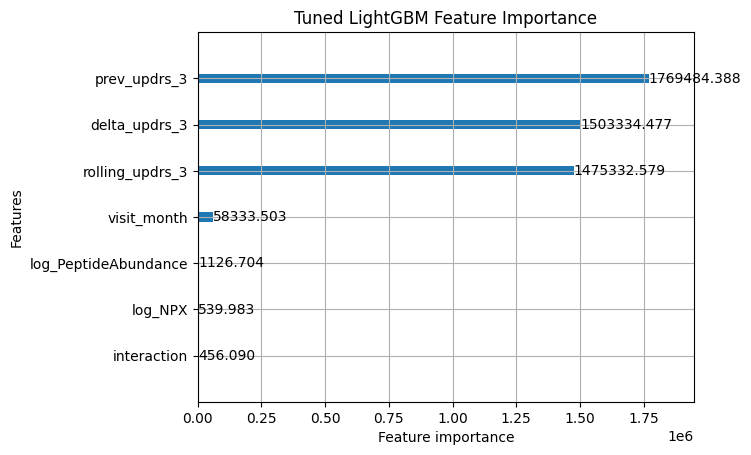

In [23]:

lgb.plot_importance(lgb_model, importance_type='gain')
plt.title("Tuned LightGBM Feature Importance")
plt.show()


In [24]:
### import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

submission_path = '/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv'

if os.path.exists(submission_path):
    submission_df = pd.read_csv(submission_path)
    composite_key_col = submission_df.columns[0]
    print("Composite key column:", composite_key_col)
    
    composite_cols = ['visit_month', 'log_PeptideAbundance', 'log_NPX', 
                      'prev_updrs_3', 'delta_updrs_3', 'rolling_updrs_3', 'interaction']
    
    test_features = submission_df[composite_key_col].str.split('_', expand=True)
    test_features.columns = composite_cols
    
    print("\nSample of split test features:")
    print(test_features.head())
    
    for col in composite_cols:
        test_features[col] = pd.to_numeric(test_features[col], errors='coerce')
    
    test_features = test_features.ffill().bfill()
    
    if test_features.isnull().sum().sum() > 0:
        print("\nThere are still missing values after ffill/bfill. Filling with median or fallback value...")
        for col in test_features.columns:
            if test_features[col].isnull().any():
                median_val = test_features[col].median()
                if pd.isna(median_val):
                    test_features[col].fillna(0, inplace=True)
                    print(f"Column {col}: filled missing values with 0")
                else:
                    test_features[col].fillna(median_val, inplace=True)
                    print(f"Column {col}: filled missing values with median value {median_val}")
    
    print("\nMissing values in test features after imputation:")
    print(test_features.isnull().sum())
    
    print("\nFinal processed test features (head):")
    print(test_features.head())
    
    features = composite_cols  # This should match the order used in training.
    
    X_test_submission_scaled = pd.DataFrame(
        scaler_features.transform(test_features),
        columns=features,
        index=test_features.index
    )
    
    print("\nScaled test features (head):")
    print(X_test_submission_scaled.head())
    
    pred_lgb_sub = lgb_model.predict(X_test_submission_scaled)
    pred_xgb_sub = xgb_model.predict(X_test_submission_scaled)
    pred_rf_sub = rf_model.predict(X_test_submission_scaled)
    
    print("\nSample predictions:")
    print("LightGBM predictions:", pred_lgb_sub[:5])
    print("XGBoost predictions:", pred_xgb_sub[:5])
    print("Random Forest predictions:", pred_rf_sub[:5])
    
    ensemble_pred_sub = (pred_lgb_sub + pred_xgb_sub + pred_rf_sub) / 3
    print("\nSample ensemble predictions:", ensemble_pred_sub[:5])
    
    submission_df.loc[:, 'predicted_updrs_3'] = ensemble_pred_sub
    
    print("\nFinal submission DataFrame (head):")
    print(submission_df.head())
    
    submission_df.to_csv('updated_submission.csv', index=False)
    print("\nUpdated submission file saved as 'updated_submission.csv'")
else:
    print("Submission file not found. Please verify the file path:", submission_path)


if 'X_test_scaled' in globals() and 'y_test' in globals():
    pred_lgb_local = lgb_model.predict(X_test_scaled)
    pred_xgb_local = xgb_model.predict(X_test_scaled)
    pred_rf_local = rf_model.predict(X_test_scaled)
    ensemble_pred_local = (pred_lgb_local + pred_xgb_local + pred_rf_local) / 3
    
    mse = mean_squared_error(y_test, ensemble_pred_local)
    rmse = mean_squared_error(y_test, ensemble_pred_local, squared=False)
    mae = mean_absolute_error(y_test, ensemble_pred_local)
    r2 = r2_score(y_test, ensemble_pred_local)
    
    print("\nEvaluation Metrics on Local Test Set:")
    print(f"  MSE: {mse:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  R²: {r2:.3f}")
else:
    print("\nLocal test set (X_test_scaled and y_test) not available for evaluation.")


Composite key column: prediction_id

Sample of split test features:
  visit_month log_PeptideAbundance log_NPX prev_updrs_3 delta_updrs_3  \
0        3342                    0   updrs            1          plus   
1        3342                    0   updrs            1          plus   
2        3342                    0   updrs            1          plus   
3        3342                    0   updrs            1          plus   
4        3342                    0   updrs            2          plus   

  rolling_updrs_3 interaction  
0               0      months  
1               6      months  
2              12      months  
3              24      months  
4               0      months  

There are still missing values after ffill/bfill. Filling with median or fallback value...
Column log_NPX: filled missing values with 0
Column delta_updrs_3: filled missing values with 0
Column interaction: filled missing values with 0

Missing values in test features after imputation:
visit_month  